Disini saya akan mengeksplorasi opini masyarakat terkait Shin Tae Yong. Informasi akan dikumpulkan melalui twitter pada 2 Januari 2022, setelah selesainya Piala AFF 2021.

Pada kesempatan ini akan dilakukan Natural Language Processing Analysis dengan tahapan:
1. Data collection
    - mengimport library yang dibutuhkan
    - membuat fungsi tweet scrapper
    - menyimpan hasil scrapping
2. Data cleaning
    - membuat fungsi agar karakter dalam tweet hanya terdiri dari huruf.
    - mengubah kata slang ke dalam format KBBI.
    - membersihkan stopword
3. Analisis sentimen
    - membuat fungsi analisis sentimen
    - visualisasi hasil
4. Exploratory Data Analysis
    - deskripsi data
    - visualisasi wordcloud untuk kata yang paling sering muncul
    - visualisasi networkx untuk hubungan antar kata
5. Topic analisis
    - menentukan nilai k, alpha dan beta
    - menentukan topik
    - labeling topik untuk tiap tweet

# 1.Data collection 

## import library

Pada cell ini kita akan mengimport *library* yang dibutuhkan untuk mengumpulkan, mengolah dan memvisualisasikan data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, tweepy, requests, re, string, nltk, tqdm
import networkx as nx
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from bs4 import BeautifulSoup 
from urllib.request import urlopen
from wordcloud import WordCloud
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import LdaMulticore
from pprint import pprint
from gensim.utils import ClippedCorpus

## membuat fungsi scraping tweet

pada cell di bawah dibuat *function* untuk mendapatkan tweet yang berkaitan dengan topik yang akan dianalisis

In [2]:
class tweets_grabber :
    def __init__(self):
        # menginput token API Twitter yang sudah disimpan dalam file .json
        with open("token.json")as f:
            tokens = json.load(f)
        
        # membaca key dari token API 
        self.api_key = tokens['api_key']
        self.api_key_secret = tokens['api_key_secret']
        self.access_token = tokens['access_token']
        self.access_token_secret = tokens['access_token_secret']
    
    # menginisiasi autentikasi tweepy.API versi 1
    def auth_v1(self):
        self.auth = tweepy.OAuthHandler(self.api_key, self.api_key_secret)
        self.auth.set_access_token(self.access_token, self.access_token_secret)
        self.api_1 = tweepy.API(self.auth, wait_on_rate_limit=True)
        return self.api_1
  
    # membuat fungsi yang memanfaatkan search_tweets dari tweepy
    def search_scraper(self, query, max_result):
        response = tweepy.Cursor(self.auth_v1().search_tweets,
                                 q=query,
                                 lang='id',
                                 tweet_mode= 'extended'
                                 ).items(max_result)
        results = [tweet.full_text.strip() for tweet in response]
        return results

Pada *function search_scraper* kita dapat memberi 2 argumen yaitu *query* dan *max_result* yang bisa diinput saat pemanggilan function. *Query* sendiri memiliki berbagai parameter yang dapat dicek di https://developer.twitter.com/en/docs/twitter-api/v1/rules-and-filtering/search-operators . 

In [8]:
# kata kunci pencarian "shin tae yong" dengan filter agar retweet tidak diambil, 
query = "shin tae yong -filter:retweets"
max_result = 1000

# hasil scrapping
hasil_twitter = tweets_grabber().search_scraper(query, max_result)

In [10]:
# membuat dataframe dari hasil scrapping
df_hasil = pd.DataFrame(hasil_twitter, columns=['tweet_raw'])
df_hasil

,tweet_raw
0,#STYSTAY\n#AFFSuzukiCup2020\nSilahkan ditonton...
1,"Tahun 2022, Ada Empat Ajang Ujian bagi Shin Ta..."
2,"Jawab Keluhan Shin Tae-yong, 3 Striker Keturun..."
3,"Berkaca Kekalahan Dari Thailand, Shin Tae-yong..."
4,Shin Tae-yong Targetkan Timnas Indonesia Juara...
...,...
995,shin tae yong pas sek dadi pak carik😂 https://...
996,"Juara gak juara, saya senang dengan timnas asu..."
997,Berikut Susunan Pemain Indonesia vs Thailand L...
998,"#TimnasDay: Pelatih Timnas Indonesia, Shin Tae..."


## menyimpan dataframe ke file csv

agar saat *file jupyter notebook* dibuka kembali kita tidak perlu mengulang pencarian data, hasil pencarian akan disimpan secara *offline* dalam *file csv*. Hal ini juga dilakukan agar data yang diolah tetap sama

In [ ]:
# dataframe disimpan sebagai file csv
df_hasil.to_csv("tweet_sty.csv",index=False)

In [2]:
# membaca data mentah dalam file csv
df = pd.read_csv("tweet_sty.csv")

# 2. cleaning data

Karena kita akan melakukan *text processing*, maka data yang didapat perlu dirapikan sehingga hanya terdapat kata-kata. Selain itu kata-kata *slang* akan diubah ke dalam KBBI.

In [3]:
def preprocessing(data):
    # mengecilkan seluruf huruf pada data
    data = data.lower()
    # menghilangkan link website
    data = re.sub(r'http\S+', '', data)
    # menghilangkan mention user
    data = re.sub(r'@\S+', '', data)
    # menghilangkan hashtag
    data = re.sub(r'#\S+', '', data)
    #menghilangkan simbol dan angka
    data = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)|('?')|('-')|(',')"," ",data)
    # menghilangkan karakter khusus dan emoticon
    data = data.encode('ascii', 'replace').decode('ascii')

    # mengubah kalimat menjadi list kata
    word_token = word_tokenize(data)
    # membuat list kosong untuk wadah hasil looping
    word_list = []
    # membaca kata-kata slang yang disimpan dalam file .json ke dalam list {slang_list}
    with open("slang.json") as s:
        slang_list = json.load(s)

    # mengubah kata-kata slang menjadi versi KBBI
    for word in word_token:
        for key, val in slang_list.items():
            if word in key:
                word = val
        word_list.append(word)
    data = ' '.join(word_list)
    
    return data

In [4]:
# menambahkan kolom baru dengan nama tweet_clean pada dataframe dengan sumber data yang telah dibersihkan
informasi = list(map(preprocessing,df['tweet_raw']))
df['tweet_clean'] = informasi
df

,tweet_raw,tweet_clean
0,#STYSTAY\n#AFFSuzukiCup2020\nSilahkan ditonton...,silahkan ditonton pendapat pelatih shin tae yo...
1,Tolong PSSI pertahankan dan perpanjang kontrak...,tolong pssi pertahankan dan perpanjang kontrak...
2,"Jawab Keluhan Shin Tae-yong, 3 Striker Keturun...",jawab keluhan shin tae yong penyerang keturuna...
3,"Berkaca Kekalahan Dari Thailand, Shin Tae-yong...",berkaca kekalahan dari thailand shin tae yong ...
4,Shin Tae-yong Targetkan Timnas Indonesia Juara...,shin tae yong targetkan timnas indonesia juara...
...,...,...
995,shin tae yong pas sek dadi pak carik😂 https://...,shin tae yong tepat sama sekali dadi memakai c...
996,"Juara gak juara, saya senang dengan timnas asu...",juara tidak juara saya senang dengan timnas as...
997,Berikut Susunan Pemain Indonesia vs Thailand L...,berikut susunan pemain indonesia vs thailand s...
998,"#TimnasDay: Pelatih Timnas Indonesia, Shin Tae...",pelatih timnas indonesia shin tae yong akan te...


# 3. analisis sentimen

analisis ini dilakukan untuk mengetahui apakah masyarakat memberi tanggapan positif atau negatif dari topik yang akan diteliti.

In [8]:
# list kosong untuk wadah hasil looping
hasil = []

def sentimen_analisis(data):   
    # membuka database kata-kata bersentimen positif dari file .txt
    positif = open("./kata_positif.txt", "r")
    positif_kata = positif.readlines()       
    # membuka database kata-kata bersentimen negatif dari file.txt
    negatif = open("./kata_negatif.txt", "r")
    negatif_kata = negatif.readlines()
    
    # list_negasi digunakan untuk mengetahui apakah kalimat secara utuh memiliki sentimen yang berbeda jika dilihat dari tiap kata
    # contoh : (saya suka apel) berbeda sentimennya dengan (saya tidak suka paprika)
    list_negasi = ['tidak','lawan','anti', 'belum', 'belom', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'sulit', 'tak', 'sblm']
    
    for kalimat in data:
        data_clean = kalimat.strip().split()
        # Nilai sentimen awal dari tiap data dimulai dengan 0/netral
        count = 0
        for word in data_clean:
            # pengecekan nilai positif, apabila benar maka nilai sentimen ditambah 1
            for posi in positif_kata:
                if posi.strip().lower() == word:
                    if data[data.index(kalimat)-1] in list_negasi:
                        count -= 1
                    else:
                        count += 1
  
            # pengecekan nilai positif, apabila benar maka nilai sentimen dikurangi 1
            for nega in negatif_kata:
                if nega.strip().lower() == word:
                    if data[data.index(kalimat)-1] in list_negasi:
                        count += 1
                    else:
                        count -= 1
                        
        hasil.append(count)

In [9]:
# menggunakan fungsi sentimen_analisis
sentimen_analisis(informasi)

# menambahkan kolom sentimen
df['sentiment'] = ["netral" if sentimen == 0 else "negatif" if sentimen < 0 else "positif" for sentimen in hasil]

In [10]:
df

,tweet_raw,tweet_clean,sentiment
0,#STYSTAY\n#AFFSuzukiCup2020\nSilahkan ditonton...,silahkan ditonton pendapat pelatih shin tae yo...,positif
1,Tolong PSSI pertahankan dan perpanjang kontrak...,tolong pssi pertahankan dan perpanjang kontrak...,netral
2,"Jawab Keluhan Shin Tae-yong, 3 Striker Keturun...",jawab keluhan shin tae yong penyerang keturuna...,negatif
3,"Berkaca Kekalahan Dari Thailand, Shin Tae-yong...",berkaca kekalahan dari thailand shin tae yong ...,negatif
4,Shin Tae-yong Targetkan Timnas Indonesia Juara...,shin tae yong targetkan timnas indonesia juara...,positif
...,...,...,...
995,shin tae yong pas sek dadi pak carik😂 https://...,shin tae yong tepat sama sekali dadi memakai c...,netral
996,"Juara gak juara, saya senang dengan timnas asu...",juara tidak juara saya senang dengan timnas as...,positif
997,Berikut Susunan Pemain Indonesia vs Thailand L...,berikut susunan pemain indonesia vs thailand s...,positif
998,"#TimnasDay: Pelatih Timnas Indonesia, Shin Tae...",pelatih timnas indonesia shin tae yong akan te...,positif


rata-rata : 0.757
standar deviasi : 1.9702667332115213


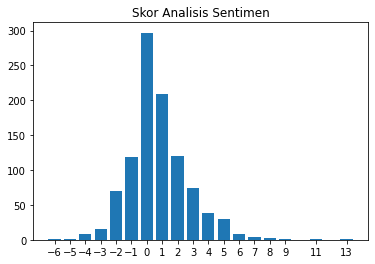

In [11]:
# rata-rata dan standar deviasi nilai sentimen
print("rata-rata :", np.mean(hasil))
print("standar deviasi :", np.std(hasil))

# menampilkan visualiasi nilai sentimen
labels, counts = np.unique(hasil, return_counts=True)
plt.title("Skor Analisis Sentimen")
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

Nilai sentimen tertinggi berada pada angka 13, sedangkan nilai sentimen terendah berada pada nilai -6. Rata-rata sentimen berada pada angka 0.76 yang menunjukkan kecendrungan sentimen positif terhadap Shin Tae Yong walau tidak terlalu tinggi.

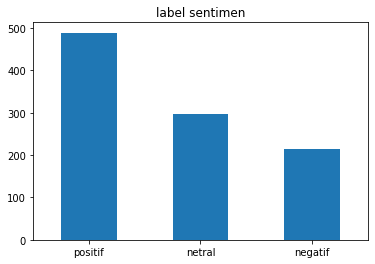

In [9]:
# visualisasi distribusi data yang telah diberi label dalam bentuk bar chart
df['sentiment'].value_counts().plot.bar()
plt.title("label sentimen")
plt.xticks(rotation=360)
plt.show()

Lebih banyak tweet yang bersentimen positif, diikuti dengan sentimen netral dan negatif. Hal ini menunjukkan bahwa masyarakat menilai Shin Tae Yong secara baik.

## membersihkan stopword
*Stopword* adalah kata-kata yang cenderung tidak memberikan makna tambahan ke dalam kalimat seperti (dan, sih, deng, adalah, itu). Kata-kata ini dihilangkan agar kata-kata yang diolah adalah kata-kata yane memiliki makna.

Pembersihan *stopword* dilakukan setelah analisis sentimen karena banyak kata-kata yang menunjukkan sentimen seperti (tidak, belum, anti) akan dihilangkan oleh *list stopword*. Disini kita akan menggunakan daftar *stopword* Bahasa Indonesia dari *library nltk.corpus*

In [13]:
# membuat fungsi
def stopword_cleaner(data):
    word_token = word_tokenize(data)
    word_list = []
    # list stopword manual sesuai kebutuhan, kata shin tae yong digunakan karena kata ini menjadi topik yang dibahas dan tidak akan memberi makna lebih ketika dijumpai
    manual_stopword = ['iya','shin','tae','yong','klik','sty']
    # list stopword dari library
    sw_indonesia = stopwords.words("indonesian")
        
    for word in word_token:
        if word not in sw_indonesia:
            if word not in manual_stopword:
                word_list.append(word)
    data = " ".join(word_list)
        
    return data

In [14]:
# memperbarui kolom tweet_clean
df['tweet_clean'] = df['tweet_clean'].apply(stopword_cleaner)
df.head()

,tweet_raw,tweet_clean,sentiment
0,#STYSTAY\n#AFFSuzukiCup2020\nSilahkan ditonton...,silahkan ditonton pendapat pelatih indonesia,positif
1,Tolong PSSI pertahankan dan perpanjang kontrak...,tolong pssi pertahankan perpanjang kontrak pel...,netral
2,"Jawab Keluhan Shin Tae-yong, 3 Striker Keturun...",keluhan penyerang keturunan pengecekan perkuat...,negatif
3,"Berkaca Kekalahan Dari Thailand, Shin Tae-yong...",berkaca kekalahan thailand siapkan timnas sea ...,negatif
4,Shin Tae-yong Targetkan Timnas Indonesia Juara...,targetkan timnas indonesia juara piala aff pel...,positif


# 4. eksploratory analisis

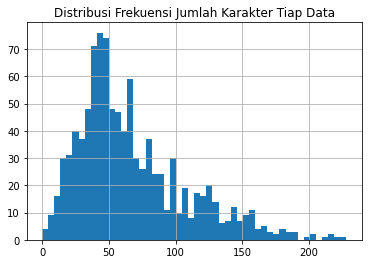

In [16]:
# analisis distribusi jumlah karakter
def char_freq_distribution(data):
    data.str.len().hist(bins=50)
    plt.title("Distribusi Frekuensi Jumlah Karakter Tiap Data")
    plt.show()

char_freq_distribution(df['tweet_clean'])

Kebanyakan data memiliki jumlah karakter antara rentang 30-70. Walau jumlah karakter sudah berkurang karena filter *stopword*, ternyata cukup banyak data yang memiliki jumlah karakter mendekati jumlah maksimal karakter yang diperbolehkan twitter (280 karakter).

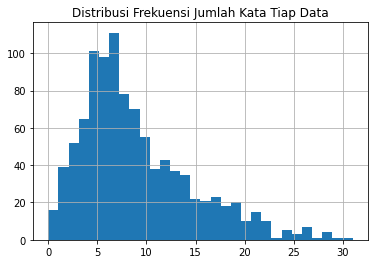

In [17]:
# analisis distribusi jumlah kata
def word_length_freq_distribution(data):
    data.str.split().map(lambda x:len(x)).hist(bins=30)
    plt.title("Distribusi Frekuensi Jumlah Kata Tiap Data")
    plt.show()

word_length_freq_distribution(df['tweet_clean'])

Jumlah kata terbanyak dalam data berada pada rentang 5-7 atau bisa diperkirakan hanya 1 atau 2 kalimat. Dapat diperkirakan bahwa masyarakat tidak menyampaikan opini secara panjang lebar.

In [15]:
# analisis kata yang paling sering muncul
def words_freq_distribution(data):
    data = data.apply(lambda x: word_tokenize(str(x)))
    kata = [word for kalimat in data for word in kalimat]
    fqdist = FreqDist(kata)
    most_common_word = fqdist.most_common(50)
    return most_common_word

jumlah_kata = words_freq_distribution(df['tweet_clean'])
jumlah_kata

[('indonesia', 457),
 ('timnas', 404),
 ('aff', 292),
 ('piala', 249),
 ('pelatih', 248),
 ('pemain', 167),
 ('pengecekan', 132),
 ('final', 116),
 ('juara', 115),
 ('kasih', 113),
 ('terima', 110),
 ('salah', 87),
 ('sabar', 86),
 ('penyerang', 80),
 ('ketua', 75),
 ('thailand', 66),
 ('muda', 61),
 ('terimakasih', 57),
 ('garuda', 56),
 ('gagal', 52),
 ('pssi', 47),
 ('gerangan', 46),
 ('bangga', 44),
 ('orang', 43),
 ('liga', 42),
 ('kambuaya', 40),
 ('latihan', 40),
 ('bagus', 35),
 ('mabuk', 34),
 ('bermain', 32),
 ('ricky', 32),
 ('turnamen', 31),
 ('semoga', 31),
 ('hotel', 31),
 ('bola', 31),
 ('pertahankan', 30),
 ('posisi', 30),
 ('kalah', 29),
 ('dilarang', 28),
 ('bertahan', 28),
 ('berjuang', 27),
 ('ahjussi', 27),
 ('klub', 26),
 ('semangat', 26),
 ('negeri', 25),
 ('perjuangan', 25),
 ('tampil', 25),
 ('asia', 24),
 ('tim', 24),
 ('korea', 24)]

Selain menyebutkan event yang baru selesai. Kata-kata yang banyak muncul adalah terimakasih, yang menunjukkan apresiasi masyarakat terhadap hasil yang telah dicapai.

## Wordcloud visualization

Pada bagian ini kita akan menganalisis 2 kata yang sering disebutkan bersamaan. Dimana sebelumnya kita baru menganalisis distribusi 1 kata. Kita akan menggunakan *library nltk.ngrams* untuk membantu dalam proses analisa.

In [18]:
# mendefinisikan fungsi
def bigram_freq_distribution(data):
    kata = [word for tweet in data['tweet_clean'] for word in tweet.split()]
    result = pd.Series(nltk.ngrams(kata, 2)).value_counts()[:20]
    print(result)

bigram_freq_distribution(df)

(timnas, indonesia)      251
(piala, aff)             228
(terima, kasih)          106
(juara, piala)            49
(pelatih, timnas)         38
(pemain, timnas)          38
(final, piala)            36
(gagal, juara)            36
(ricky, kambuaya)         31
(pemain, muda)            26
(indonesia, gagal)        24
(kasih, latihan)          23
(orang, mabuk)            23
(indonesia, juara)        23
(sistem, gelembung)       20
(final, sabar)            20
(kasih, pelatih)          20
(indonesia, piala)        20
(salah, piala)            19
(indonesia, dilarang)     18
dtype: int64


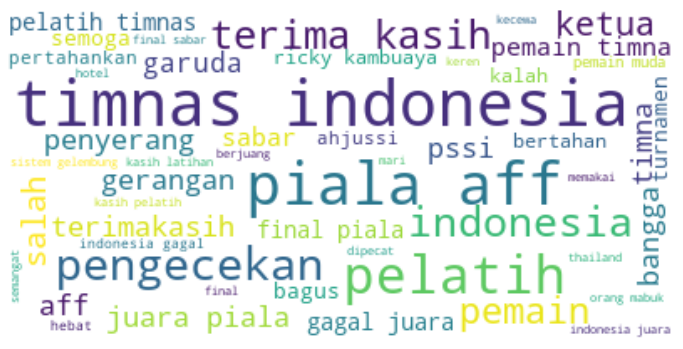

In [20]:
# visualisasi kata menggunakan wordcloud
def awan_kata(data):
    display_kata = WordCloud(max_words=50, background_color="white").generate(' '.join(data))
    plt.figure(figsize=(12,8))
    plt.imshow(display_kata, interpolation='bilinear')
    plt.axis("off") 
    plt.show()

awan_kata(df['tweet_clean']) 

Sorotan terhadap PSSI, dan permintaan untuk mempertahankan Shin Tae Yong termasuk banyak diucapkan oleh masyarakat. Ternyata nama yang paling banyak disebut adalah Ricky Kambuaya, pemain Indonesia yang dikabarkan akan bermain di luar Indonesia. Selain apresiasi, banyak juga tweet yang menyampaikan kegagalan Indonesia untuk menjadi juara.

## visualisasi networkx
sebelumnya kita telah melihat paduan kata dalam bentuk *panda Series*. Agar lebih menarik kita akan menampilkan hubungan kata dengan visualisasi menggunakan *library networkx*

In [22]:
# membuat list kata dari kolom tweet_clean
info_token = [word for tweet in df['tweet_clean'] for word in tweet.split()]

# list per kata diubah menjadi tiap 2 kata menjadi variabel info_bigram
info_bigram = nltk.ngrams(info_token, 2)

# pembobotan frekuensi info_bigram
fdist = nltk.FreqDist(info_bigram)

# membuat dataframe yang memiliki paduan kata beserta frekuensinya
list_data = [[bigram_word, weight] for bigram_word, weight in fdist.items()]
df_bigram = pd.DataFrame(list_data, columns=['bigram','count'])

# dataframe diurutkan berdasarkan nilai frekuensi dan dibatasi dengan jumlah 1000 baris
df_bigram_sort = df_bigram.sort_values(by=['count'], ascending=False).copy().reset_index(drop=True)[:1000]

df_bigram_sort

,bigram,count
0,"(timnas, indonesia)",251
1,"(piala, aff)",228
2,"(terima, kasih)",106
3,"(juara, piala)",49
4,"(pelatih, timnas)",38
...,...,...
995,"(timnya, bagus)",1
996,"(muda, timnya)",1
997,"(teruskan, perjuanganmu)",1
998,"(job, ahjussi)",1


In [23]:
# Membuat dictionary dari dataframe bigram_sort yang telah di Transpose
info_dict= df_bigram_sort.set_index("bigram").T.to_dict("records")

In [24]:
# menginput model dari networkx ke dalam variabel G
G = nx.Graph()
nodes_size=[]

# mengisi data ke dalam model G
for node, weight in info_dict[0].items():
    G.add_edge(node[0], node[1], weight=weight*10)

In [25]:
# membuat variabel deg_val yang menampung nilai degree dari model G
deg_val = dict(G.degree)

# membuat filter yang membatasi hanya kata kata dengan frekuensi lebih dari 10
deg_filter = G.degree
items_filter = [n for n in deg_filter if n[1]>10]

node = [node[0] for node in items_filter]
degree = [node[1] for node in items_filter]

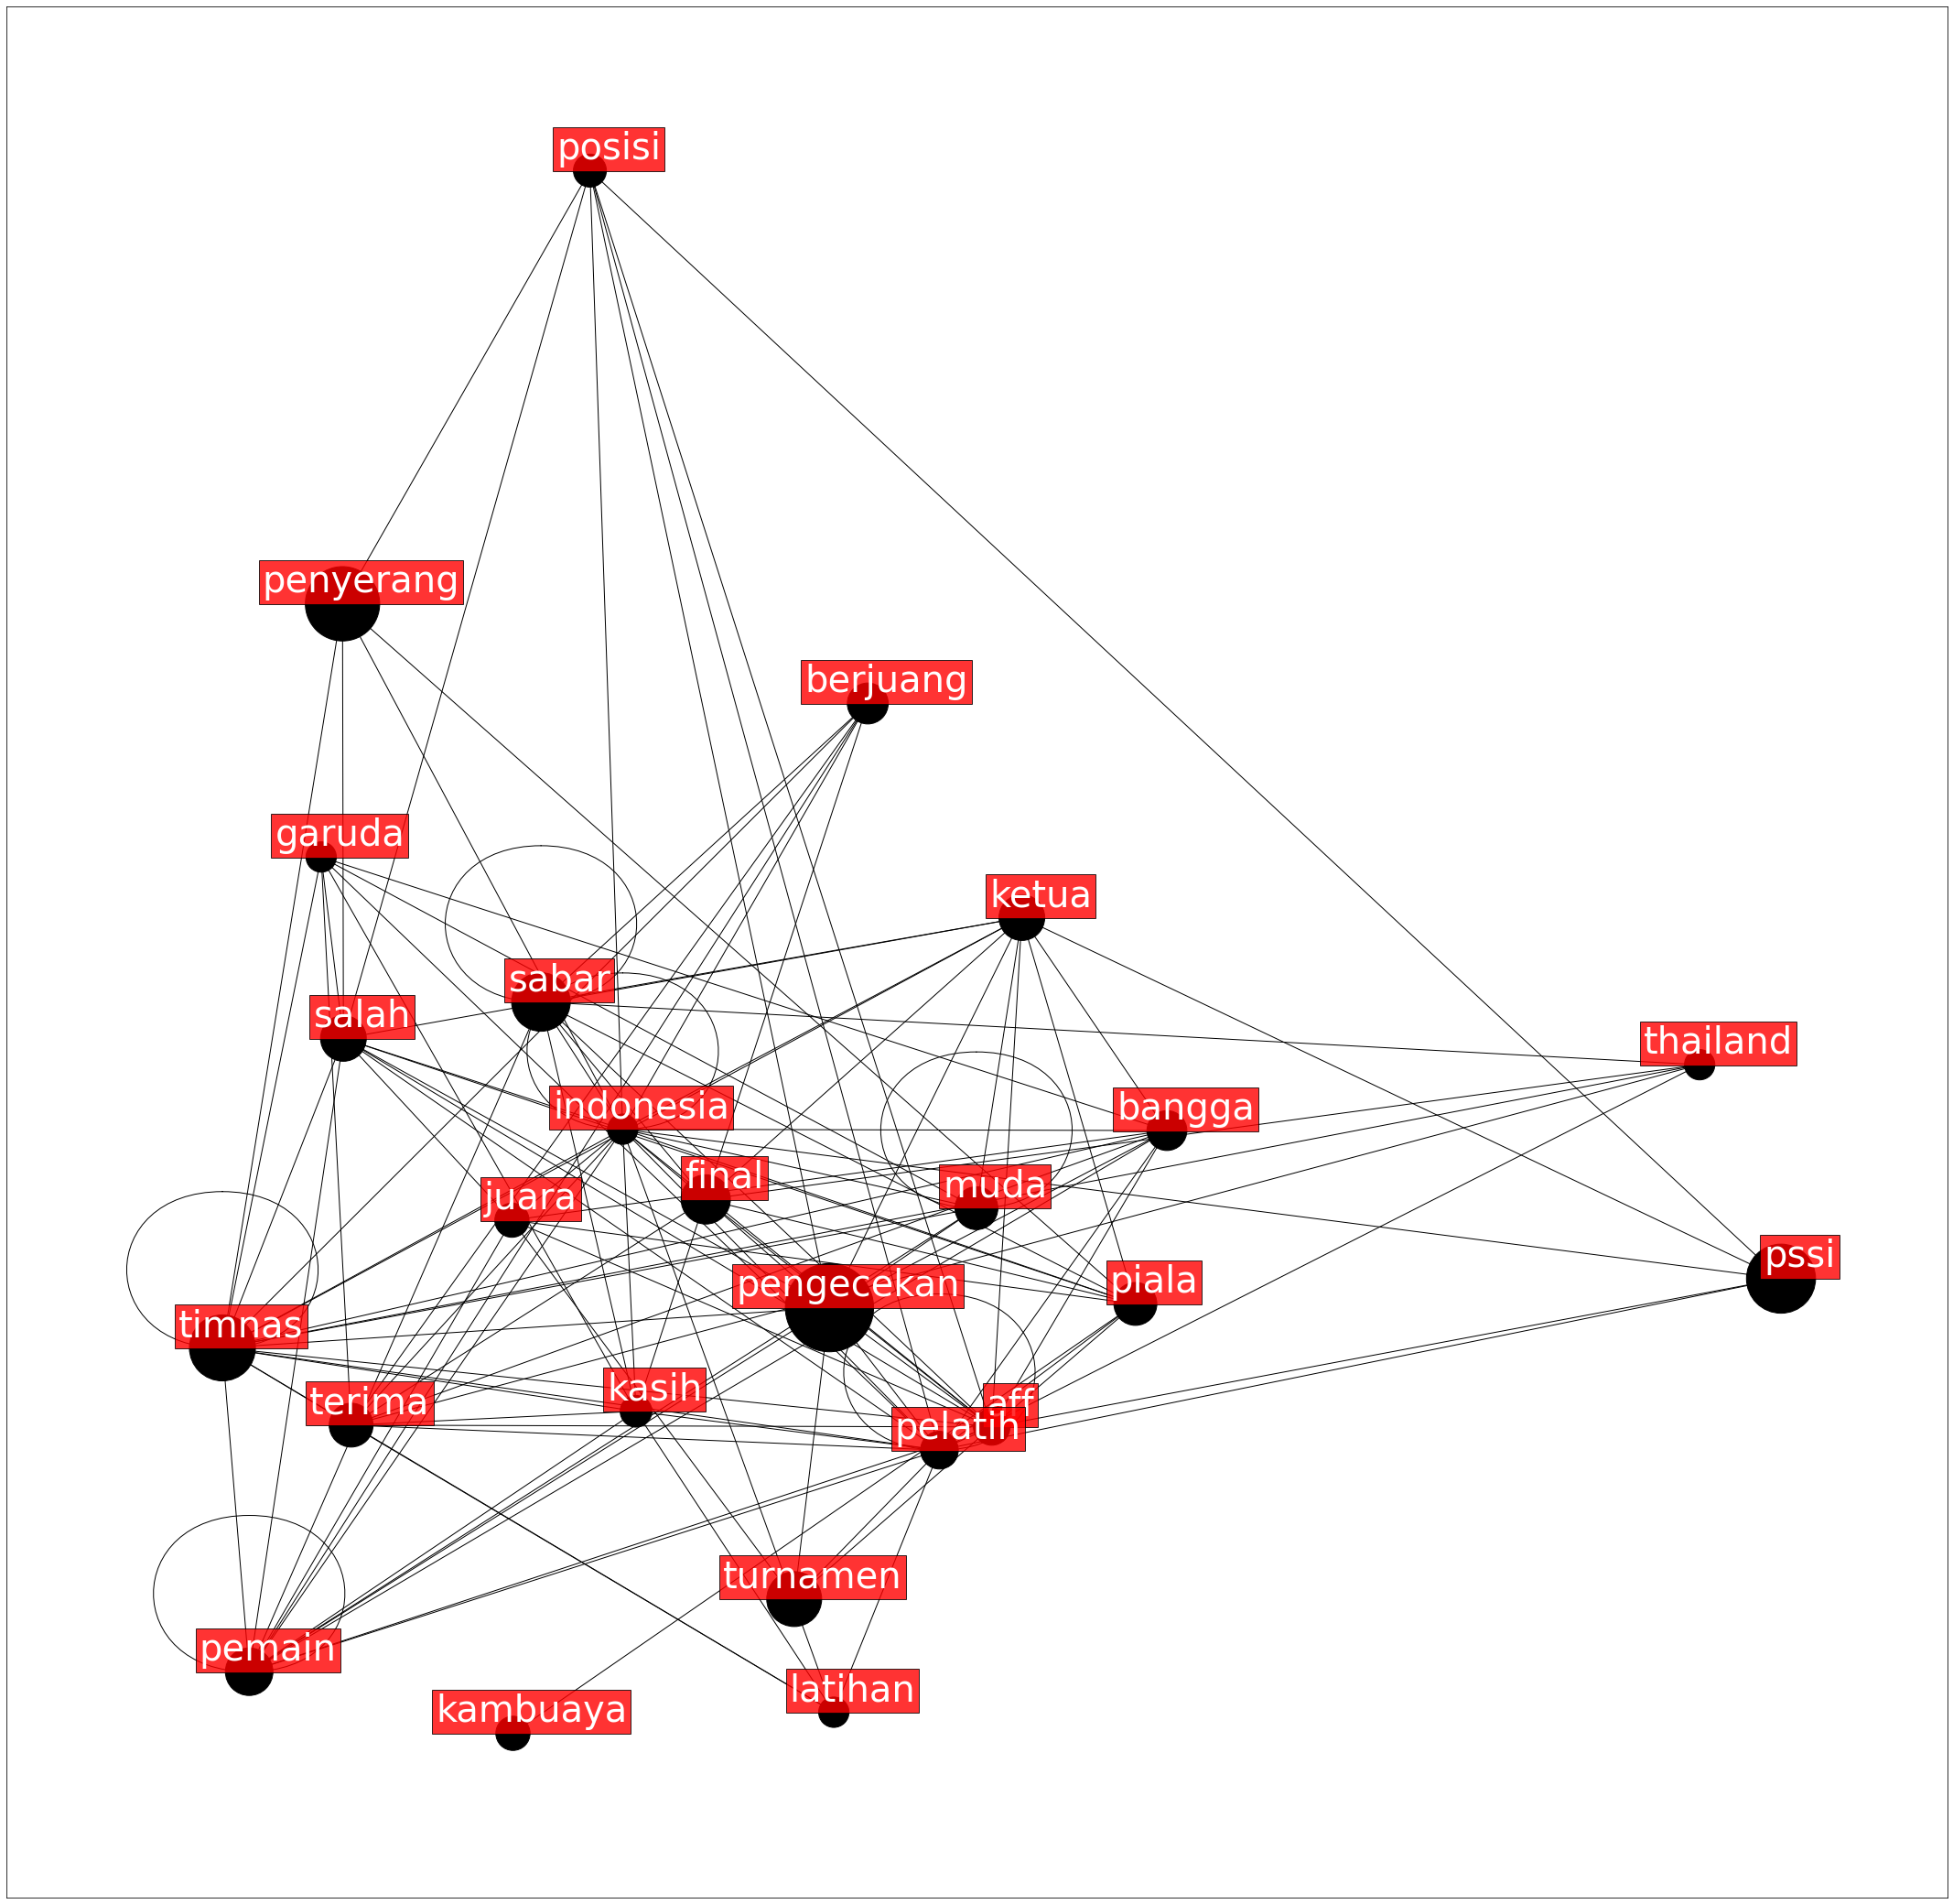

In [26]:
# pembuatan figure matplotlib
fig, ax = plt.subplots(figsize=(38,38))

# penentuan posisi key dan value
pos = nx.spring_layout(G, k=1.5)

# Data yang telah difilter kemudian diplot ke dalam Grafik dengan nama variabel {k}
k = G.subgraph(node)

# plotting networkx
nx.draw_networkx(
    k,
    pos,
    with_labels = False,
    node_size = [weight*100 for weight in degree],
    node_color = 'black',
    ax = ax
)
# pembuatan label
for key, value in pos.items():
    if key in node:
        x, y = value[0]+.005, value[1]+.005 
        ax.text(x,y, s=key,
                bbox=dict(facecolor='red', alpha=0.8),
                horizontalalignment='center', fontsize=40, color='white')

plt.show()

Pemain dengan posisi penyerang menjadi pemain dengan sorotan utama. Banyak juga ajakan untuk sabar, dan tetap berjuang sembari berlatih yang disampaikan masyarakat. Final Indonesia melawan Thailand juga menjadi kata yang sering muncul.

# 5. topic analisis

mencari nilai k (jumlah topik), alpha, beta

In [27]:
# LD, Gensim
info_tokens = [word_tokenize(info) for info in df["tweet_clean"]]
dictd = corpora.Dictionary(info_tokens)

In [28]:
doc_term_matrix = [dictd.doc2bow(doc) for doc in info_tokens]

In [29]:
def compute_coherence_values(corpus, dictionary, k, a, b):
      lda_model = LdaMulticore(corpus = doc_term_matrix,
                               id2word = dictd,
                               num_topics = k,
                               random_state = 100,
                               chunksize = 100,
                               passes = 10,
                               alpha = a,
                               eta =b)
  
      coherence_model_lda = CoherenceModel(model=lda_model, texts=info_tokens, dictionary=dictd, coherence='c_v')
      return coherence_model_lda.get_coherence()

In [ ]:
# rentang topic
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

#beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

#validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [#gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25),
               #gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5),
               ClippedCorpus(doc_term_matrix, num_of_docs*0.75),
               doc_term_matrix]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha' : [],
                 'Beta' : [],
                 'Coherence' : []
                 }

if 1 == 1:
    pbar = tqdm.tqdm(total=540)

    #iterasi validation corpuses
    for i in range(len(corpus_sets)):
        #iterasi jumlah topik
        for k in topics_range:
            # iterasi nilai alpha
            for a in alpha:
                # iterasi nilai beta
                for b in beta:
                    # nilai coherence
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictd, k=k, a=a, b=b)

                    # menyimpan hasil model
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)

    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

In [31]:
# membaca hasil model LDA
df_tuning_data = pd.read_csv("lda_tuning_results.csv")

## mencari nilai k

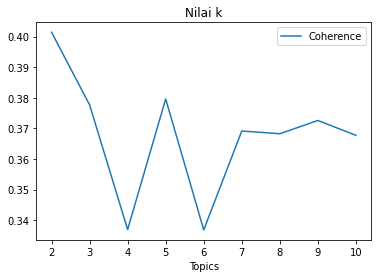

In [32]:
df_plot = df_tuning_data[(df_tuning_data.Alpha == "0.01") & (df_tuning_data.Beta == "0.31") & (df_tuning_data.Validation_Set == "100% Corpus")].copy()
df_plot.plot(x='Topics', y='Coherence', kind='line')
plt.title("Nilai k");

## mencari nilai alpha dan beta

In [33]:
# mencari alpha & beta
df_plot_2 = df_tuning_data[(df_tuning_data.Topics == 3) & (df_tuning_data.Validation_Set == "100% Corpus")].copy()
df_plot_2.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
328,100% Corpus,3,asymmetric,0.9099999999999999,0.442441
327,100% Corpus,3,asymmetric,0.61,0.438517
329,100% Corpus,3,asymmetric,symmetric,0.420339
323,100% Corpus,3,symmetric,0.9099999999999999,0.415191
308,100% Corpus,3,0.31,0.9099999999999999,0.413620
326,100% Corpus,3,asymmetric,0.31,0.408710
303,100% Corpus,3,0.01,0.9099999999999999,0.405661
318,100% Corpus,3,0.9099999999999999,0.9099999999999999,0.399753
312,100% Corpus,3,0.61,0.61,0.399553
313,100% Corpus,3,0.61,0.9099999999999999,0.398934


**Ditemukan bahwa nilai k terbaik adalah 3, nilai alpha =0.9 dan nilai beta 0.9**

In [34]:
# input nilai ke dalam model
lda_model = LdaMulticore(corpus = doc_term_matrix,
                         id2word = dictd,
                         num_topics = 3,             #nilai k
                         random_state = 100,
                         chunksize = 100,
                         passes = 10,
                         alpha = 0.9,               #nilai alpha
                         eta =0.9)                  #nilai beta

In [35]:
# print topik
pprint(lda_model.print_topics())

[(0,
  '0.042*"timnas" + 0.038*"indonesia" + 0.035*"pelatih" + 0.021*"kasih" + '
  '0.020*"aff" + 0.020*"terima" + 0.017*"pemain" + 0.015*"pengecekan" + '
  '0.015*"piala" + 0.014*"final"'),
 (1,
  '0.009*"pengecekan" + 0.008*"oppa" + 0.008*"timnas" + 0.006*"gerangan" + '
  '0.005*"korea" + 0.005*"bertahan" + 0.005*"salah" + 0.004*"pemain" + '
  '0.004*"dipecat" + 0.004*"tertawa"'),
 (2,
  '0.026*"indonesia" + 0.016*"aff" + 0.015*"piala" + 0.012*"timnas" + '
  '0.011*"penyerang" + 0.007*"liga" + 0.007*"kambuaya" + 0.007*"pemain" + '
  '0.005*"orang" + 0.005*"ricky"')]


Terdapat 3 topik dari dataset ini yaitu

0. Ucapan terimakasih kepada Timnas Indonesia dan pelatih berdasarkan hasil Final Piala AFF
1. Permintaan agar Shin Tae Yong bertahan dan, perlu diadakannya pengecekan. Ternyata banyak pula masyarakat yang menyebut pelatih asal Korea ini dengan istilah oppa, sebuah ucapan dalam Bahasa Korea. Ini menunjukkan bahwa budaya Korea sudah banyak diserap oleh masyarakat Indonesia.
2. Sorotan terhadap penyerang Indonesia, dan pembicaraan terkait salah satu pemain yaitu Ricky Kambuaya.

In [36]:
# menambah kolom news_topic ke dataframe
for i in range(3):
    col_name = 'news_topic_'+str(i)
    df[col_name] = 0

df

,tweet_raw,tweet_clean,sentiment,news_topic_0,news_topic_1,news_topic_2
0,#STYSTAY\n#AFFSuzukiCup2020\nSilahkan ditonton...,silahkan ditonton pendapat pelatih indonesia,positif,0,0,0
1,Tolong PSSI pertahankan dan perpanjang kontrak...,tolong pssi pertahankan perpanjang kontrak pel...,netral,0,0,0
2,"Jawab Keluhan Shin Tae-yong, 3 Striker Keturun...",keluhan penyerang keturunan pengecekan perkuat...,negatif,0,0,0
3,"Berkaca Kekalahan Dari Thailand, Shin Tae-yong...",berkaca kekalahan thailand siapkan timnas sea ...,negatif,0,0,0
4,Shin Tae-yong Targetkan Timnas Indonesia Juara...,targetkan timnas indonesia juara piala aff pel...,positif,0,0,0
...,...,...,...,...,...,...
995,shin tae yong pas sek dadi pak carik😂 https://...,dadi memakai carik,netral,0,0,0
996,"Juara gak juara, saya senang dengan timnas asu...",juara juara senang timnas asuhan pemain muda f...,positif,0,0,0
997,Berikut Susunan Pemain Indonesia vs Thailand L...,susunan pemain indonesia vs thailand sabar mem...,positif,0,0,0
998,"#TimnasDay: Pelatih Timnas Indonesia, Shin Tae...",pelatih timnas indonesia berjuang sabar final ...,positif,0,0,0


In [37]:
# memasukkan nilai model LDA ke dalam dataframe
for row_index, row in df.iterrows():
    row =row.copy()
    new_doc = dictd.doc2bow(word_tokenize(row['tweet_clean']))
    
    lda_result = lda_model[new_doc]
    for tpc in lda_result:
        col_name = 'news_topic_'+(str(tpc[0]).strip())
        df.loc[row_index, col_name] = float(tpc[1]) 

In [38]:
df

,tweet_raw,tweet_clean,sentiment,news_topic_0,news_topic_1,news_topic_2
0,#STYSTAY\n#AFFSuzukiCup2020\nSilahkan ditonton...,silahkan ditonton pendapat pelatih indonesia,positif,0.439959,0.205766,0.354275
1,Tolong PSSI pertahankan dan perpanjang kontrak...,tolong pssi pertahankan perpanjang kontrak pel...,netral,0.580167,0.271183,0.148650
2,"Jawab Keluhan Shin Tae-yong, 3 Striker Keturun...",keluhan penyerang keturunan pengecekan perkuat...,negatif,0.394096,0.144960,0.460944
3,"Berkaca Kekalahan Dari Thailand, Shin Tae-yong...",berkaca kekalahan thailand siapkan timnas sea ...,negatif,0.235900,0.202023,0.562077
4,Shin Tae-yong Targetkan Timnas Indonesia Juara...,targetkan timnas indonesia juara piala aff pel...,positif,0.801425,0.089472,0.109102
...,...,...,...,...,...,...
995,shin tae yong pas sek dadi pak carik😂 https://...,dadi memakai carik,netral,0.174773,0.576666,0.248561
996,"Juara gak juara, saya senang dengan timnas asu...",juara juara senang timnas asuhan pemain muda f...,positif,0.877916,0.069878,0.052206
997,Berikut Susunan Pemain Indonesia vs Thailand L...,susunan pemain indonesia vs thailand sabar mem...,positif,0.808944,0.087716,0.103341
998,"#TimnasDay: Pelatih Timnas Indonesia, Shin Tae...",pelatih timnas indonesia berjuang sabar final ...,positif,0.828975,0.075338,0.095687


In [39]:
# memberi label berdasarkan kedekatan terhadap topik
def flag_df(df):
    if (df['news_topic_0'] > df['news_topic_1']) & (df['news_topic_0'] > df['news_topic_2']):
        return 'Topic 0'
    elif (df['news_topic_1'] > df['news_topic_0']) & (df['news_topic_1'] > df['news_topic_2']):
        return 'Topic 1'
    elif (df['news_topic_2'] > df['news_topic_1']) & (df['news_topic_2'] > df['news_topic_0']):
        return 'Topic 2'

In [40]:
df['Topic'] = df.apply(flag_df, axis = 1)

In [41]:
df

,tweet_raw,tweet_clean,sentiment,news_topic_0,news_topic_1,news_topic_2,Topic
0,#STYSTAY\n#AFFSuzukiCup2020\nSilahkan ditonton...,silahkan ditonton pendapat pelatih indonesia,positif,0.439959,0.205766,0.354275,Topic 0
1,Tolong PSSI pertahankan dan perpanjang kontrak...,tolong pssi pertahankan perpanjang kontrak pel...,netral,0.580167,0.271183,0.148650,Topic 0
2,"Jawab Keluhan Shin Tae-yong, 3 Striker Keturun...",keluhan penyerang keturunan pengecekan perkuat...,negatif,0.394096,0.144960,0.460944,Topic 2
3,"Berkaca Kekalahan Dari Thailand, Shin Tae-yong...",berkaca kekalahan thailand siapkan timnas sea ...,negatif,0.235900,0.202023,0.562077,Topic 2
4,Shin Tae-yong Targetkan Timnas Indonesia Juara...,targetkan timnas indonesia juara piala aff pel...,positif,0.801425,0.089472,0.109102,Topic 0
...,...,...,...,...,...,...,...
995,shin tae yong pas sek dadi pak carik😂 https://...,dadi memakai carik,netral,0.174773,0.576666,0.248561,Topic 1
996,"Juara gak juara, saya senang dengan timnas asu...",juara juara senang timnas asuhan pemain muda f...,positif,0.877916,0.069878,0.052206,Topic 0
997,Berikut Susunan Pemain Indonesia vs Thailand L...,susunan pemain indonesia vs thailand sabar mem...,positif,0.808944,0.087716,0.103341,Topic 0
998,"#TimnasDay: Pelatih Timnas Indonesia, Shin Tae...",pelatih timnas indonesia berjuang sabar final ...,positif,0.828975,0.075338,0.095687,Topic 0


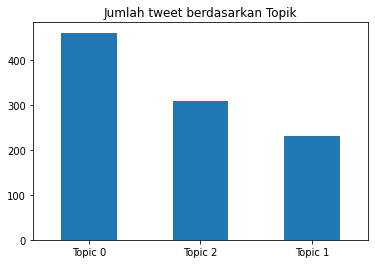

In [42]:
# Plot topik 
df['Topic'].value_counts().plot.bar()
plt.title("Jumlah tweet berdasarkan Topik")
plt.xticks(rotation=360);

Terlihat bahwa Topik 0 menjadi topik yang paling banyak diperbincangkan.

In [43]:
# Karena tidak ada lagi transaksi yang dibatalkan. Kolom "Cancellation" akan dihapus
df = df.drop(['news_topic_0','news_topic_1','news_topic_2'],axis=1)
df

,tweet_raw,tweet_clean,sentiment,Topic
0,#STYSTAY\n#AFFSuzukiCup2020\nSilahkan ditonton...,silahkan ditonton pendapat pelatih indonesia,positif,Topic 0
1,Tolong PSSI pertahankan dan perpanjang kontrak...,tolong pssi pertahankan perpanjang kontrak pel...,netral,Topic 0
2,"Jawab Keluhan Shin Tae-yong, 3 Striker Keturun...",keluhan penyerang keturunan pengecekan perkuat...,negatif,Topic 2
3,"Berkaca Kekalahan Dari Thailand, Shin Tae-yong...",berkaca kekalahan thailand siapkan timnas sea ...,negatif,Topic 2
4,Shin Tae-yong Targetkan Timnas Indonesia Juara...,targetkan timnas indonesia juara piala aff pel...,positif,Topic 0
...,...,...,...,...
995,shin tae yong pas sek dadi pak carik😂 https://...,dadi memakai carik,netral,Topic 1
996,"Juara gak juara, saya senang dengan timnas asu...",juara juara senang timnas asuhan pemain muda f...,positif,Topic 0
997,Berikut Susunan Pemain Indonesia vs Thailand L...,susunan pemain indonesia vs thailand sabar mem...,positif,Topic 0
998,"#TimnasDay: Pelatih Timnas Indonesia, Shin Tae...",pelatih timnas indonesia berjuang sabar final ...,positif,Topic 0
